In [29]:
import pandas as pd

In [30]:
import glob
import os

labels = ["multiple-models-on-one-machine-support", "round-robin"]  # Lista schedulerów

files = []

for scheduler in labels:
    scheduler_files = glob.glob(f"../requests/requests_{scheduler}_*")
    
    newest_file = max(scheduler_files, key=os.path.getmtime)
    
    files.append(newest_file)
print(files)

['../requests/requests_multiple-models-on-one-machine-support_2024-06-08_18-58-52.csv', '../requests/requests_round-robin_2024-06-10_09-32-07.csv']


In [31]:
# labels = ["multiple-models-on-one-machine-support", "round-robin"]
# files = ['../requests/requests_multiple-models-on-one-machine-support_2024-06-05_11-21-33.csv', '../requests/requests_round-robin_2024-06-10_05-37-41.csv']

In [32]:
dfs = []
for f in files:
    df = pd.read_csv(f)
    df["arrival_time"] = pd.to_datetime(df["arrival_time"])
    df["start_time"] = pd.to_datetime(df["start_time"])
    df["finish_time"] = pd.to_datetime(df["finish_time"])
    df["response_time"] = (df["finish_time"] - df["arrival_time"]).dt.total_seconds()
    df["service_time"] = (df["finish_time"] - df["start_time"]).dt.total_seconds()
    start_time = df["arrival_time"].min()
    df["arrival_time"] = (df["arrival_time"] - start_time).dt.total_seconds()

    # df = df[df["arrival_time"] <= start_time + pd.Timedelta(minutes=20)]
    dfs.append(df)

In [33]:
def plot_cdfs(dfs, labels, column):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots()
    for i, df in enumerate(dfs):
        data = df[column]
        data = np.sort(data)
        yvals = np.arange(len(data))/float(len(data))
        ax.plot(data, yvals, label=labels[i])
    ax.set_xscale('log')
    ax.set_xlabel(column)
    ax.set_ylabel("CDF")
    ax.legend()
    plt.show()

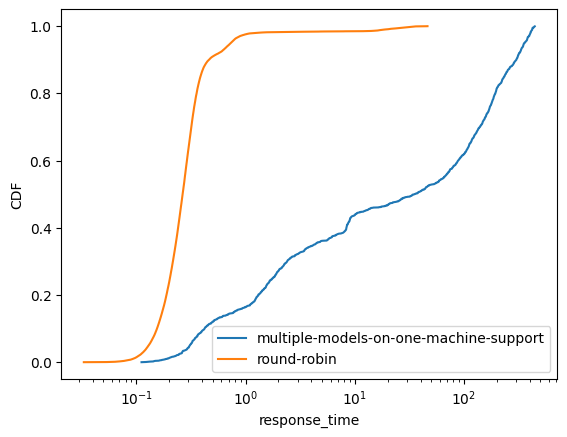

In [34]:
plot_cdfs(dfs, labels, "response_time")

In [35]:
dfs[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804 entries, 0 to 1803
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           1804 non-null   object        
 1   arrival_time                 1804 non-null   float64       
 2   model                        1804 non-null   object        
 3   expected_machine_type        1804 non-null   object        
 4   sla_time_seconds             1804 non-null   int64         
 5   continuous_batching_support  1804 non-null   bool          
 6   input_tokens                 1804 non-null   int64         
 7   output_tokens                1804 non-null   int64         
 8   start_time                   1804 non-null   datetime64[ns]
 9   finish_time                  1804 non-null   datetime64[ns]
 10  response_time                1804 non-null   float64       
 11  service_time                 1804 non-null 

In [36]:
def print_starved_requests(df):
    starved_requests = df[df["service_time"] > df['sla_time_seconds']]
    print(starved_requests)

In [37]:
print_starved_requests(dfs[0])

                                           id  arrival_time  \
74    168312215071219485511501463592068689192       114.974   
77    308538428708266157036243864435739691063        83.978   
81     34443573901884470510694891328644438421       124.924   
89    202518132550824514612509426164436082798       162.917   
103   269496014091330691656239106525499954303       207.048   
...                                       ...           ...   
1761  327563475565877547040129310522413709827       417.447   
1765   77845752349611923002450121996422739034       406.161   
1770  203821467923003447359384250162850631340       395.080   
1771  178428316760566800519844135577865845563       405.144   
1773   22652129152309001305750367683792200630       406.222   

                                    model expected_machine_type  \
74      1+1+1+c5.18xlarge+1-llama_7B-conv           c5.18xlarge   
77      1+1+1+c5.18xlarge+1-llama_7B-conv           c5.18xlarge   
81      1+1+1+c5.18xlarge+1-llama_7B-conv 

In [38]:
for df in dfs:
    df["met_sla"] = df["response_time"]  <= df["sla_time_seconds"]

In [39]:
def plot_sla(dfs, labels):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots()
    for i, df in enumerate(dfs):
        met_sla_percentage = df["met_sla"].sum() / len(df)
        ax.bar(labels[i], met_sla_percentage, label=labels[i])
    ax.set_ylabel("Percentage of requests meeting SLA")
    ax.set_xticklabels([])
    ax.legend(loc='lower left')
    plt.show()

In [40]:
def print_sla(dfs, labels):
    for i, df in enumerate(dfs):
        met_sla_percentage = df["met_sla"].sum() / len(df)
        print(f"{labels[i]}: {met_sla_percentage}")

In [41]:
print_sla(dfs, labels)

multiple-models-on-one-machine-support: 0.47838137472283815
round-robin: 0.9706370483850376


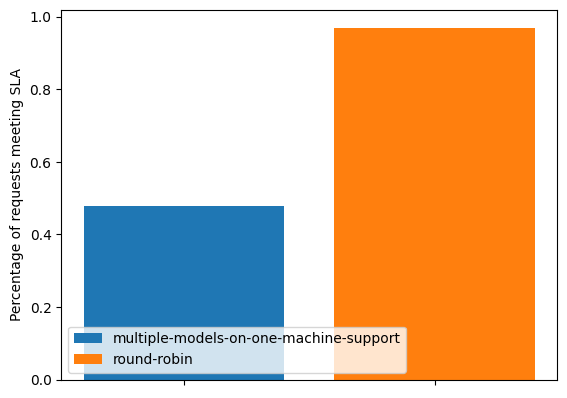

In [42]:
plot_sla(dfs, labels)

In [43]:
min([], default=0)

0

In [44]:
dfs[0].head()

,id,arrival_time,model,expected_machine_type,sla_time_seconds,continuous_batching_support,input_tokens,output_tokens,start_time,finish_time,response_time,service_time,met_sla
0,202058737569698026277408139850974354577,8.259,1+1+1+c5.18xlarge+0.5-llama_7B-conv,c5.18xlarge,30,False,54,424,2024-06-08 18:50:54.308846,2024-06-08 18:50:57.267936,123.078529,2.959090,False
1,260509479527869246956769626946566121304,48.303,1+1+1+c5.18xlarge+0.5-llama_7B-conv,c5.18xlarge,30,False,1059,65,2024-06-08 18:50:55.979107,2024-06-08 18:50:56.440169,82.206762,0.461062,False
2,18179492332230255241305763382295894447,3.778,1+1+1+c5.18xlarge+0.5-llama_7B-conv,c5.18xlarge,30,False,67,12,2024-06-08 18:50:54.151226,2024-06-08 18:50:54.248291,124.539884,0.097065,False
3,299887783132220062161426222253833999475,109.532,1+1+1+c5.18xlarge+0.5-llama_7B-conv,c5.18xlarge,30,False,4082,470,2024-06-08 18:50:57.441858,2024-06-08 18:51:00.717639,25.255232,3.275781,True
4,265455867499497028019682113672826842311,108.978,1+1+1+c5.18xlarge+0.5-llama_7B-conv,c5.18xlarge,30,False,383,84,2024-06-08 18:50:57.232113,2024-06-08 18:50:57.824626,22.916219,0.592513,True


In [45]:
# plot distribution (in time) of starved requests
def plot_starved_requests(dfs, labels):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots()
    for i, df in enumerate(dfs):
        df_starved = df[df["met_sla"] == False]
        arrival_times = df_starved["arrival_time"]
        ax.hist(arrival_times, bins=20, label=labels[i])
        for rect in ax.patches:
            rect.set_alpha(0.5)
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of starved requests")
    ax.legend()
    plt.show()


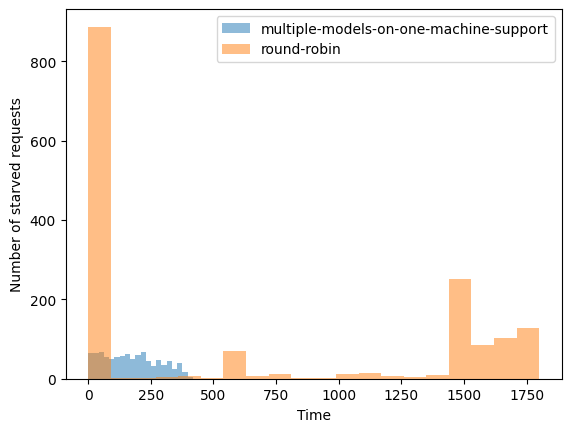

In [46]:
plot_starved_requests(dfs, labels)

In [47]:
def plot_starved_requests_models(df):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots()
    for model, group in df.groupby('model'):
        group_starved = group[group["met_sla"] == False]
        arrival_times = group_starved["arrival_time"]
        ax.hist(arrival_times, bins=20, label=model)
        for rect in ax.patches:
            rect.set_alpha(0.5)
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of starved requests")
    ax.legend()
    plt.show()

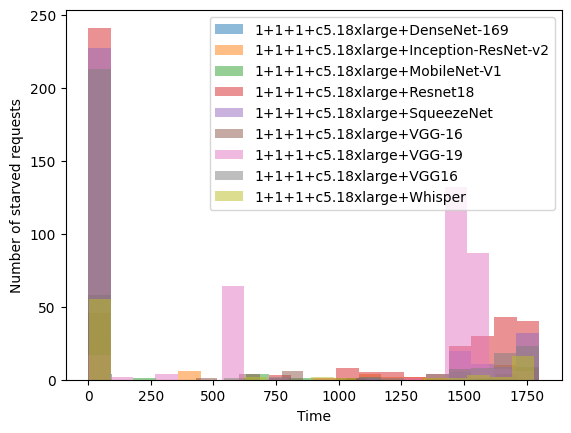

In [48]:
plot_starved_requests_models(dfs[1])

In [49]:
# count starved requests per model
def count_starved_requests_per_model(df):
    for model, group in df.groupby('model'):
        starved_requests = group[group["met_sla"] == False]
        print(f"{model}: {len(starved_requests)}")

In [50]:
def count_starved_percent_per_model(df):
    for model, group in df.groupby('model'):
        starved_requests = group[group["met_sla"] == False]
        print(f"{model}: {len(starved_requests) / len(group)}")

In [51]:
count_starved_requests_per_model(dfs[1])

1+1+1+c5.18xlarge+DenseNet-169: 6
1+1+1+c5.18xlarge+Inception-ResNet-v2: 66
1+1+1+c5.18xlarge+MobileNet-V1: 88
1+1+1+c5.18xlarge+Resnet18: 405
1+1+1+c5.18xlarge+SqueezeNet: 300
1+1+1+c5.18xlarge+VGG-16: 63
1+1+1+c5.18xlarge+VGG-19: 321
1+1+1+c5.18xlarge+VGG16: 278
1+1+1+c5.18xlarge+Whisper: 83


In [52]:
count_starved_percent_per_model(dfs[1])

1+1+1+c5.18xlarge+DenseNet-169: 0.031413612565445025
1+1+1+c5.18xlarge+Inception-ResNet-v2: 0.029372496662216287
1+1+1+c5.18xlarge+MobileNet-V1: 0.03150733977801647
1+1+1+c5.18xlarge+Resnet18: 0.025948231676063558
1+1+1+c5.18xlarge+SqueezeNet: 0.026669037247755358
1+1+1+c5.18xlarge+VGG-16: 0.03669190448456611
1+1+1+c5.18xlarge+VGG-19: 0.061400153022188216
1+1+1+c5.18xlarge+VGG16: 0.01969954648526077
1+1+1+c5.18xlarge+Whisper: 0.04922894424673784


In [53]:
count_starved_requests_per_model(dfs[0])

1+1+1+c5.18xlarge+0.5-llama_7B-code: 7
1+1+1+c5.18xlarge+0.5-llama_7B-conv: 3
1+1+1+c5.18xlarge+1-llama_7B-code: 249
1+1+1+c5.18xlarge+1-llama_7B-conv: 38
1+1+1+c5.18xlarge+1.5-llama_7B-code: 60
1+1+1+c5.18xlarge+1.5-llama_7B-conv: 584
